# M508 Individual final project - Léonie Lavaert

## Introduction

Natural language processing makes it possible to execute sentiment analysis. With the help of machine learning, businesses can analyze text and classify them into groups of positive or negative sentiments towards their product or service. With the help of this information, companies can improve the products or services, help the customers more accurately and enhance customer loyalty. Historical data makes it also possible to predict future customer actions and behavior, which makes it possible for a company to anticipate and work toward positive sentiments (Robinson, 2021). With the help of APIs of social media platforms, web scraping tools and existing open-source repositories of data it is possible to collect the data to create the model (Saurabhk, 2020). 

Spotify is one of the biggest music streaming platforms in terms of subscribers (Iqbal, 2022). While having almost 422 users in 2022, the user experience and sentiment of the customers are extremely important for the success of the company. Therefore a sentiment analysis of reviews given in the Google Play Store is performed in this pipeline. Text classification will make it possible to classify reviews into different categories of sentiment.

## System design

In the first step, all the needed libraries are imported. They are required to have a functional model. In the second step, data is collected and explored. The dataset that was used can be found on Kaggle and is loaded in. After loading the data, the data is explored. In the third step, the data is preprocessed. First, the most important features are selected. Then, the text is preprocessed by removing punctuations, stop words, and many other things to improve the performance of the NLP model. In the fourth step, the text is vectorized before training and testing the model in the last steps. 

## Importing libraries

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import nltk
import sklearn.model_selection
import sklearn.feature_extraction.text
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import imblearn.over_sampling

## Data collection

The used dataset can be found on Kaggle and accessed through the following URL: https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022. This dataset is loaded, in the next step.

### Loading dataset

In [2]:
df = pd.read_csv("reviews.csv")
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


### Data exploration

After loading in the dataset, the data is now being explored to identify any remarkable things about the data such as imbalanced classes, missing values or unnecessary features.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In this column above it is visible that there are five columns. The reply column has a lot of missing values. Consequently, will this column be removed in the next step. The whole dataset consists of 61.594 reviews and for every review there is a rating. To increase the speed of training and not overload the server, 30.000 random reviews will be selected to form the dataset to create this model. In the column above it is visible that there are five columns. The reply column has a lot of missing values. Consequently, will this column be removed in the next step. The whole dataset consists of 61.594 reviews and for every review there is a rating. To increase the speed of training and not overload the server, 30.000 random reviews will be selected to form the dataset to create this model. 

In [4]:
df = df.sample(n=30000)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 22640 to 51238
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  30000 non-null  object
 1   Review          30000 non-null  object
 2   Rating          30000 non-null  int64 
 3   Total_thumbsup  30000 non-null  int64 
 4   Reply           112 non-null    object
dtypes: int64(2), object(3)
memory usage: 1.4+ MB


In [5]:
df.describe()

,Rating,Total_thumbsup
count,30000.000000,30000.000000
mean,3.154067,7.192633
std,1.677843,78.607633
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,5.000000,6026.000000


Above, the distribution of the numeral columns is shown. The rating column has a range of 1 to 5 which refers to the reviewers giving one or up to five stars. There does not seem anything remarkable or wrong with the numerical data.

In [15]:
df.loc[1,"Review"]

'Please ignore previous negative rating. This app is super great. I give it five stars+'

When randomly looking at a specific review, it is possible to see that to improve the performance of the model punctuations will need to be removed as well as white spaces and capital letters. 

In [16]:
df[["Review", "Total_thumbsup"]].nlargest(10, "Total_thumbsup")

,Review,Total_thumbsup
37523,Forever glitchy. App play button and current s...,6026
36670,Edit April 13: the reliability and stability o...,4749
22039,I have used almost every music provider except...,4115
44953,I'm facing lot of bugs on my mobile. I subscri...,2907
40840,Very poor experience with the free version. I ...,2721
58520,It is the best music app you can find... But b...,2524
48597,I'm going to be honest. This app is great. I a...,2427
8038,Been waiting for the update with lyrics on pho...,2290
34247,Only giving 4 stars instead of 5 because of th...,2129
24552,I've been using Spotify for a long time and it...,2077


Next, in the table above it is possible to see the first ten reviews that were liked the most. Considering that one likes means that someone found that specific review interesting, this can be a very informative result. Spotify could prioritize and identify important aspects or features that need to be adapted in the current service. So next to the model that is following in this pipeline for sentiment analysis this could be an important tool as well.

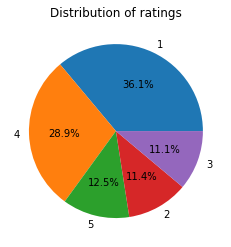

In [17]:
plt.pie(df['Rating'].value_counts(), labels=df['Rating'].unique(), autopct='%1.1f%%')
plt.title("Distribution of ratings")
plt.show()

After visualizing the different ratings, which will be the target class, it is visible that the classes are unbalanced. Also when considering the interpretation of the model the amount of start does not say a lot. Therefore the categories will be divided into positive, neutral and negative in the data preprocessing step. 

## Data preprocessing

In what follows the most important features are first selected, then the text is preprocessed and lastly, the dataset is split into training and testing. 

### Feature selection

Below, the ratings are divided into three different categories to make it easier to interpret the outcome. Ratings with 1 and 2 stars are given the category negative, ratings with 3 stars are neutral and ratings with 4 and 5 stars are considered positive. These categories are stored in the new column "Sentiment".

In [18]:
conditions = [
    df["Rating"] >= 4,
    df["Rating"] == 3,
    df["Rating"] <= 2,
]

values = ['Positive', 'Neutral', 'Negative']

df['Sentiment'] = np.select(conditions, values)
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply,Sentiment
22640,2022-05-13 12:20:18,"**Update: May 13 - Just downloaded another ""Up...",1,176,NaN,Negative
49901,2022-02-24 18:03:56,Maybe there is an easier way of finding a part...,4,1,NaN,Positive
5435,2022-06-27 17:42:24,Lots of advertisements,1,0,NaN,Negative
13501,2022-06-08 18:08:24,"Lovely, enjoying music and very clear",5,0,NaN,Positive
43380,2022-03-21 12:47:45,best app for music but sometimes ads are distu...,5,0,NaN,Positive


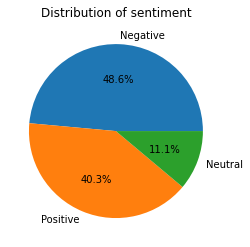

In [19]:
plt.pie(df['Sentiment'].value_counts(), labels=df['Sentiment'].unique(), autopct='%1.1f%%')
plt.title("Distribution of sentiment")
plt.show()

Next up, the columns "Time_submitted and "Reply" are being deleted. As seen in the data preprocessing step the column "Reply" has a lot of null values and is not accurate for the sentiment analysis. Furthermore, the time does not add any valuable additional information for the sentiment analysis. 

In [23]:
del df["Time_submitted"]
del df["Reply"]
df.head()

,Review,Rating,Total_thumbsup,Sentiment
22640,"**Update: May 13 - Just downloaded another ""Up...",1,176,Negative
49901,Maybe there is an easier way of finding a part...,4,1,Positive
5435,Lots of advertisements,1,0,Negative
13501,"Lovely, enjoying music and very clear",5,0,Positive
43380,best app for music but sometimes ads are distu...,5,0,Positive


### Text preprocessor

The next text preprocessing step is crucial to transfer the text from human language to a format that is readable by machines (Davydova, 2018). The built preprocessor is first going to lower the text to then tokenize it. Stop words are being removed and the words are being lemmatized. 

In [24]:
def preprocessor(text):
    text = text.lower()
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    words = tokenizer.tokenize(text)
    stop_words = nltk.corpus.stopwords.words("english")
    words_without = [w for w in words if not w in stop_words]
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemm_words = [lemmatizer.lemmatize(w) for w in words_without]
    return " ".join(lemm_words)

df["preprocessed_text"] = df["Review"].apply(preprocessor)
df.head()

,Review,Rating,Total_thumbsup,Sentiment,preprocessed_text
22640,"**Update: May 13 - Just downloaded another ""Up...",1,176,Negative,update may 13 downloaded another update nothin...
49901,Maybe there is an easier way of finding a part...,4,1,Positive,maybe easier way finding particular song one p...
5435,Lots of advertisements,1,0,Negative,lot advertisement
13501,"Lovely, enjoying music and very clear",5,0,Positive,lovely enjoying music clear
43380,best app for music but sometimes ads are distu...,5,0,Positive,best app music sometimes ad disturbing irritating


### Split data

Now the dataset is divided into a test and training dataset. The test dataset will be kept until the end to evaluate how well the model is performing. 

In [25]:
x = df["preprocessed_text"]
y = df["Sentiment"]
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((22500,), (7500,), (22500,), (7500,))

There is no need to encode the labels why scikit learn is being used and labeling is happening automatically. 

## Feature engineering

Since the text is not straightforward to represent, a vector space model will be introduced. In that way, the text will be converted to a  numerical form. The words will be represented as TF-IDF, which assigns an importance score to each word (Sowmya Vajjala et al., 2020). In the next step, the vectorizer is defined, fitted on the training data and then transformed to the whole database. 

### Vectorizer

In [36]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(min_df=3, max_features=10000)
vectorizer.fit(x_train)

x_train_tfidf = vectorizer.transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

print("x_train_tfidf:", x_train_tfidf.shape)
print("x_test_tfidf:", x_test_tfidf.shape)

x_train_tfidf: (22500, 4416)
x_test_tfidf: (7500, 4416)


The two hyperparameters used are the min_df and max_features. Min_df means that the terms with a lower frequency than three will be ignored. The max_features is going to make sure only the 10.000 most frequent terms will be used to build a vocabulary (Scikit learn, 2018).

### Balancing classes

As seen in the data exploration part, the classes are unbalanced, therefore the SMOTE method is being applied to the training data. This will apply an over-sampling technique to the dataset. The hyperparameter sampling_strategy will make sure all classes are resampled. While building the pipeline all the different sampling strategies were tried, but the "all" strategy delivered the best performance when evaluating the trained model. Therefore, the hyperparameter was set that way.

In [37]:
smote = imblearn.over_sampling.SMOTE(random_state = 2, sampling_strategy = "all")  
x_train_res, y_train_res = smote.fit_resample(x_train_tfidf, y_train)

## Training a model

After preprocessing the data and feature engineering it is now time to train the right model and evaluate the model based on how well it is classifying the reviews in the right categories. 

### Random forest

The first used algorithm is random forest. This algorithm creates decision trees on random selected samples of data, gets a prediction for each tree and selects the best solution by voting (Datacamp, 2018). Grid search is applied to find the best hyperparameters.

In [39]:
parameters_grid = {
    "criterion": ["gini", "entropy"],
    "n_estimators": range(250,510,50)
}
RF = sklearn.model_selection.GridSearchCV(sklearn.ensemble.RandomForestClassifier(),
                                              parameters_grid, scoring="accuracy", cv=5, n_jobs=-1)
RF.fit(x_train_res, y_train_res)
print("Accuracy of the best RF classifier = {:.2f}".format(RF.best_score_))
print("Best found hyperparameters of RF classifier = {}".format(RF.best_params_))

Accuracy of the best RF classifier = 0.87
Best found hyperparameters of RF classifier = {'criterion': 'entropy', 'n_estimators': 400}


### Multilayer perceptron

The second chosen algorithm is a multilayer perceptron. Before training the model, scaling the data is necessary. Therefore the data is being scaled in the next step. 

In [40]:
scaler = sklearn.preprocessing.StandardScaler(with_mean=False)
scaler.fit(x_train_res)

x_train_sc = scaler.transform(x_train_res)
x_test_sc = scaler.transform(x_test_tfidf)

Early stopping was set to true which will make sure 10% of the training data is set aside as validation ad the training will be terminated when the validation score is not improving. The max_iter specifies the number of epochs and batch_size determines the size of the mini batches. Finally, the solver means the solver used for weight optimization (Scikit learn, 2010). 

In [41]:
parameters_grid = { 
    "solver": ["lbfgs", "adam"],
    "batch_size":[300, 400],
    "max_iter": [600, 700],
    "early_stopping": [True]
}
ML = sklearn.model_selection.GridSearchCV(sklearn.neural_network.MLPClassifier(),
                                              parameters_grid, scoring="accuracy", cv=5, n_jobs=-1)
ML.fit(x_train_sc, y_train_res)
print("Accuracy of the best MLP classifier = {:.2f}".format(ML.best_score_))
print("Best found hyperparameters of MLP classifier = {}".format(ML.best_params_))

Accuracy of the best MLP classifier = 0.85
Best found hyperparameters of MLP classifier = {'batch_size': 400, 'early_stopping': True, 'max_iter': 700, 'solver': 'adam'}


The model that obtained the highest accuracy is random forest. Therefore that model is tested in the following steps.

## Testing the best model

In [44]:
y_predicted = RF.predict(x_test_tfidf)
accuracy = sklearn.metrics.accuracy_score(y_test, y_predicted)
cm = sklearn.metrics.confusion_matrix(y_test, y_predicted)
precision, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(y_test, y_predicted)

print("Accuracy = ", accuracy)
print("Precision = ", precision)
print("Recall =", recall)
print("F1-score =", f1)
print("Confusion Matrix:\n", cm) 

Accuracy =  0.7530666666666667
Precision =  [0.7022942  0.25365854 0.83398329]
Recall = [0.85088293 0.06124853 0.83328695]
F1-score = [0.769481   0.09867173 0.83363497]
Confusion Matrix:
 [[2602   74  382]
 [ 583   52  214]
 [ 520   79 2994]]


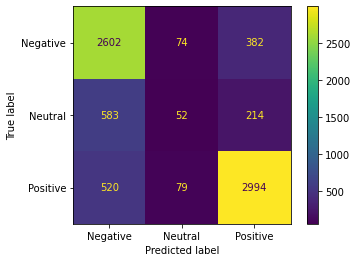

In [46]:
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=RF.classes_)
disp.plot()
plt.show()

When testing the final model an accuracy of 75% is obtained, which means 75% of the reviews are classified in the right class. This is not very high and means that the model is not performing very well. When calculating the evaluation metrics it is also visible that the model has in particular difficulties with assigning the class neutral to a review which is not surprising since it is even difficult to determine what exactly is defined as neutral. 

Looking at the confusion matrix still, the majority of positive and negative reviews are classified correctly.

### Testing new reviews

As final evaluation, some random reviews were formulated to see if the model classified them correctly.

In [54]:
review = ["This is a bad app!", "I love how good the songs are.", "I'am experiencing a lot of bugs terrible."]
encoded_review = vectorizer.transform(review)
predicted_class = RF.predict(encoded_review)
predicted_class

array(['Positive', 'Positive', 'Negative'], dtype=object)

Again, this shows how average the model is performing. It classifies the first review as positive but it is clear that that is not the case. 

## Discussion

Spotify is one of the most used music platforms and fully relies on its subscribers. Therefore, the opinions and reviews of their customers are extremely important to stay successful. With the help of a database containing reviews about Spotify given on the Google Play Store, two models were trained to perform a multiclass classification task. The best-performing model was random forest classification. Evaluating the model with the test set accuracy of 75% was obtained, which is not that high. Nevertheless, considering the shortage of time and capability of the server this is the best possible obtained model. 

What could be interesting for Spotify is to observe the reviews with the most likes, considering that those reviews contain the most interesting information.

This pipeline could serve as a foundation for further research. Further studies could opt for a more advanced way to represent the text. Word embeddings could result in a higher accuracy. Furthermore, other balancing or scaling technqiues could be tried out as well. Finally, other algorithms and hyperparameters could improve the performance as well. 

## References

Datacamp (2018). Sklearn Random Forest Classifiers in Python Tutorial. [online] www.datacamp.com. Available at: https://www.datacamp.com/tutorial/random-forests-classifier-python.

Davydova, O. (2018). Text Preprocessing in Python: Steps, Tools, and Examples. [online] Product AI. Available at: https://medium.com/product-ai/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908.

ILMI, M.F. (2022). Spotify App Reviews. [online] www.kaggle.com. Available at: https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022.

Iqbal, M. (2022). Spotify Usage and Revenue Statistics (2022). [online] Business of Apps. Available at: https://www.businessofapps.com/data/spotify-statistics/.

Robinson, S. (2021). Sentiment analysis: Why it’s necessary and how it improves CX. [online] SearchCustomerExperience. Available at: https://www.techtarget.com/searchcustomerexperience/tip/Sentiment-analysis-Why-its-necessary-and-how-it-improves-CX.

Saurabhk (2020). Data Collection and Annotation Measures for Sentiment Analysis. [online] Analytics Vidhya. Available at: https://medium.com/analytics-vidhya/data-collection-and-annotation-measures-for-sentiment-analysis-767da1dd4272.

Scikit learn (2010). sklearn.neural_network.MLPClassifier — scikit-learn 0.20.3 documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html.

Scikit learn (2018). sklearn.feature_extraction.text.TfidfVectorizer — scikit-learn 0.20.3 documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html.

Sowmya Vajjala, Bodhisattwa Majumder, Anuj Gupta and Harshit Surana (2020). Practical natural language processing : a comprehensive guide to building real-world NLP sysems. Sebastopol, Ca O’reilly Media.